<a href="https://colab.research.google.com/github/poojan007/ICT619-Waste-Sorting-Assistant/blob/main/ICT619_Assignment_1_SmartSort_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SmartSort Model
This model performs a process for data augmentation, and training a convolutional neural network (CNN) using Transfer Learning using VGG16 and MobileNetV2 on image data for classifying waste images into recyclable and organic.



In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 29 02:03:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Upload file by mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/mntDrive')

Mounted at /mntDrive


In [3]:
# load data from google drive and unzip it

!unzip -q /mntDrive/MyDrive/ICT619-Dataset/archive.zip -d data

## Importing Libraries

In [4]:
import os
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten, Rescaling
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from keras.metrics import Precision, Recall

## Define dataset paths

In [5]:
### Google Colab Setup ###
train_dir = '/content/data/DATASET/TRAIN'
test_dir = '/content/data/DATASET/TEST'

### Local Setup ###
#train_dir = 'DATASET\\TRAIN'
#test_dir = 'DATASET\\TEST'

## Data Analysis

The dataset contains images divided into training and test sets all in jpg format. Therefore, no data labeling was required as the images were already labelled into two categories 'R' and 'O', recyclable and Organic, respectively.

In [6]:
class_names = os.listdir((train_dir))
print(f'Number of categories: {len(class_names)}')
print(f'Names of categories: {class_names}')

Number of categories: 2
Names of categories: ['O', 'R']


In [7]:
def count_images(directory, classes):
    return {class_name: len(glob(os.path.join(directory, class_name, '*'))) for class_name in classes}

count_train = count_images(train_dir, class_names)
count_test = count_images(test_dir, class_names)

total_train_images = sum(count_train.values())
total_test_images = sum(count_test.values())

print(f'Total number of images in train set: {total_train_images}')
print(f'Total number of images in test set: {total_test_images}')

Total number of images in train set: 22564
Total number of images in test set: 2513


Plotting number of images in train set:

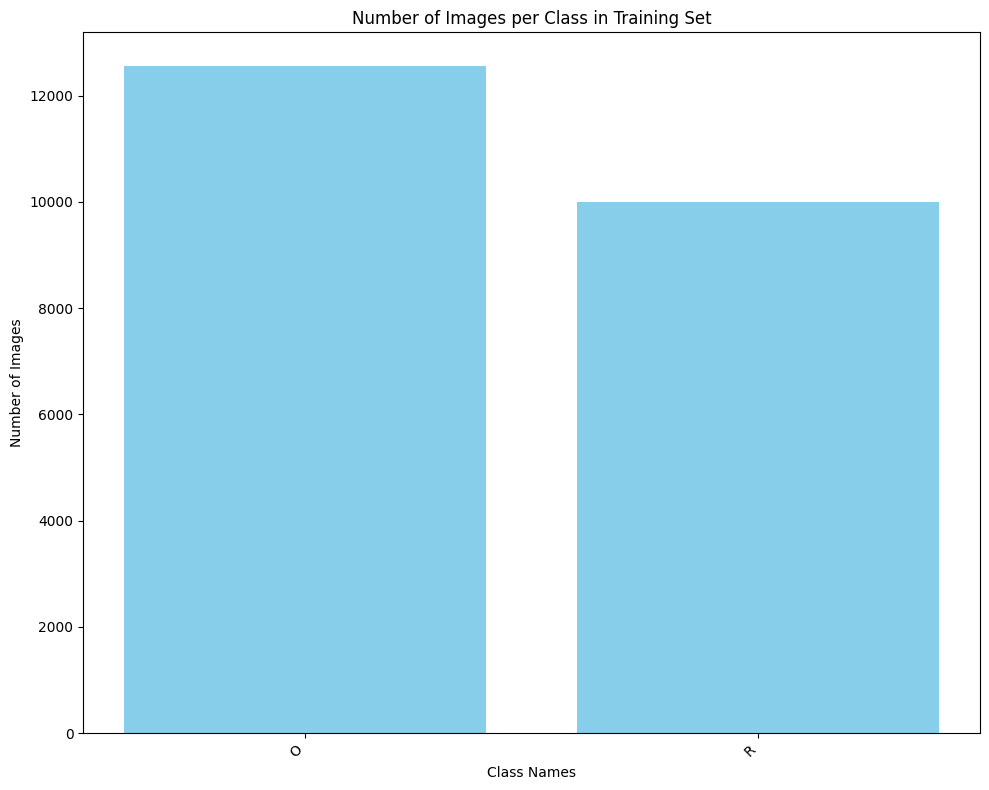

In [8]:
classes = list(count_train.keys())  # Extract class names
train_counts = [count_train[class_name] for class_name in classes]  # Extract counts for each class

plt.figure(figsize=(10, 8))  # Optional: Adjusts the figure size
plt.bar(classes, train_counts, color='skyblue')  # Creates the bar plot
plt.xlabel('Class Names')  # X-axis label
plt.ylabel('Number of Images')  # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate class names for better readability
plt.title('Number of Images per Class in Training Set')  # Chart title
plt.tight_layout()  # Adjust layout to not cut off labels

plt.show()  # Display the plot

Plotting number of images in the test set:

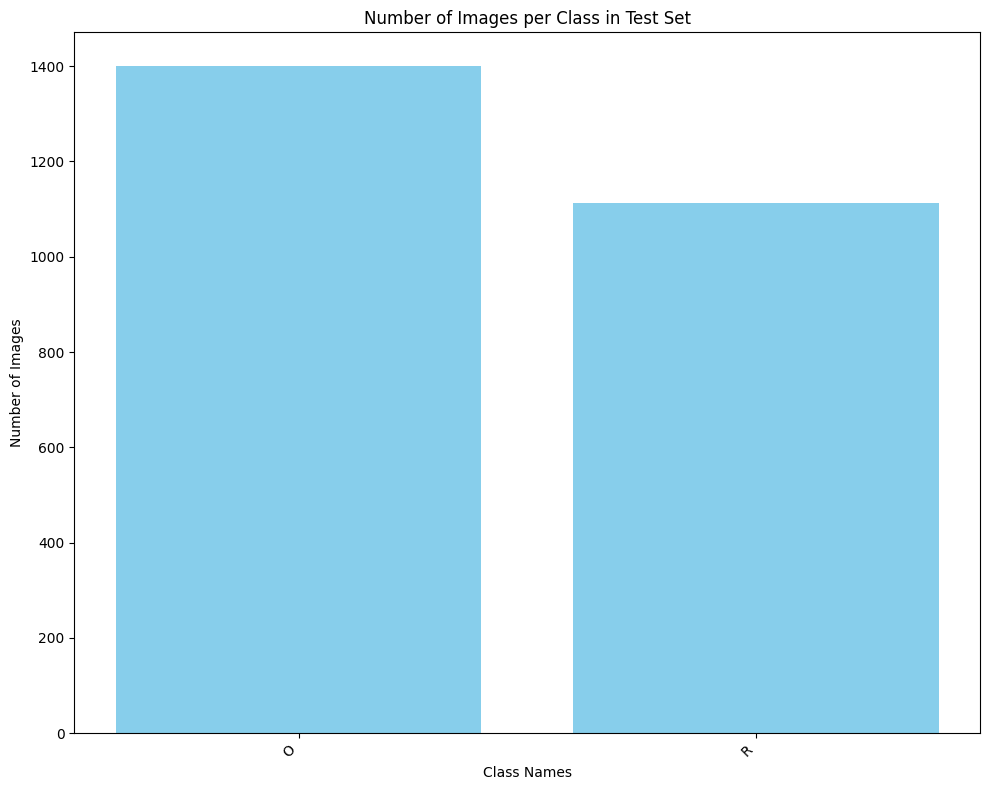

In [9]:
classes = list(count_test.keys())  # Extract class names
train_counts = [count_test[class_name] for class_name in classes]  # Extract counts for each class

plt.figure(figsize=(10, 8))  # Optional: Adjusts the figure size
plt.bar(classes, train_counts, color='skyblue')  # Creates the bar plot
plt.xlabel('Class Names')  # X-axis label
plt.ylabel('Number of Images')  # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate class names for better readability
plt.title('Number of Images per Class in Test Set')  # Chart title
plt.tight_layout()  # Adjust layout to not cut off labels

plt.show()  # Display the plot

## Data preparation

We perform data augmentation on our dataset. To develop a transformation that rescales the images and applies data augmentation, we utilized ImageDataGenerator. We only augment the training data. The validation data is only rescaled.

In [10]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)


Now we split the data into training and test sets and change the image size to 224.

In [11]:
batch_size = 32
image_size = (224, 224)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                 target_size = image_size,
                                                 shuffle = True,
                                                 class_mode = 'binary')

validation_generator = validation_datagen.flow_from_directory(test_dir,
                                            target_size = image_size,
                                            shuffle = True,
                                            class_mode = 'binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [12]:
train_generator.class_indices

{'O': 0, 'R': 1}

In [13]:
train_generator.image_shape

(224, 224, 3)

In [14]:
validation_generator.image_shape

(224, 224, 3)

Visualizing sample images from the training set:

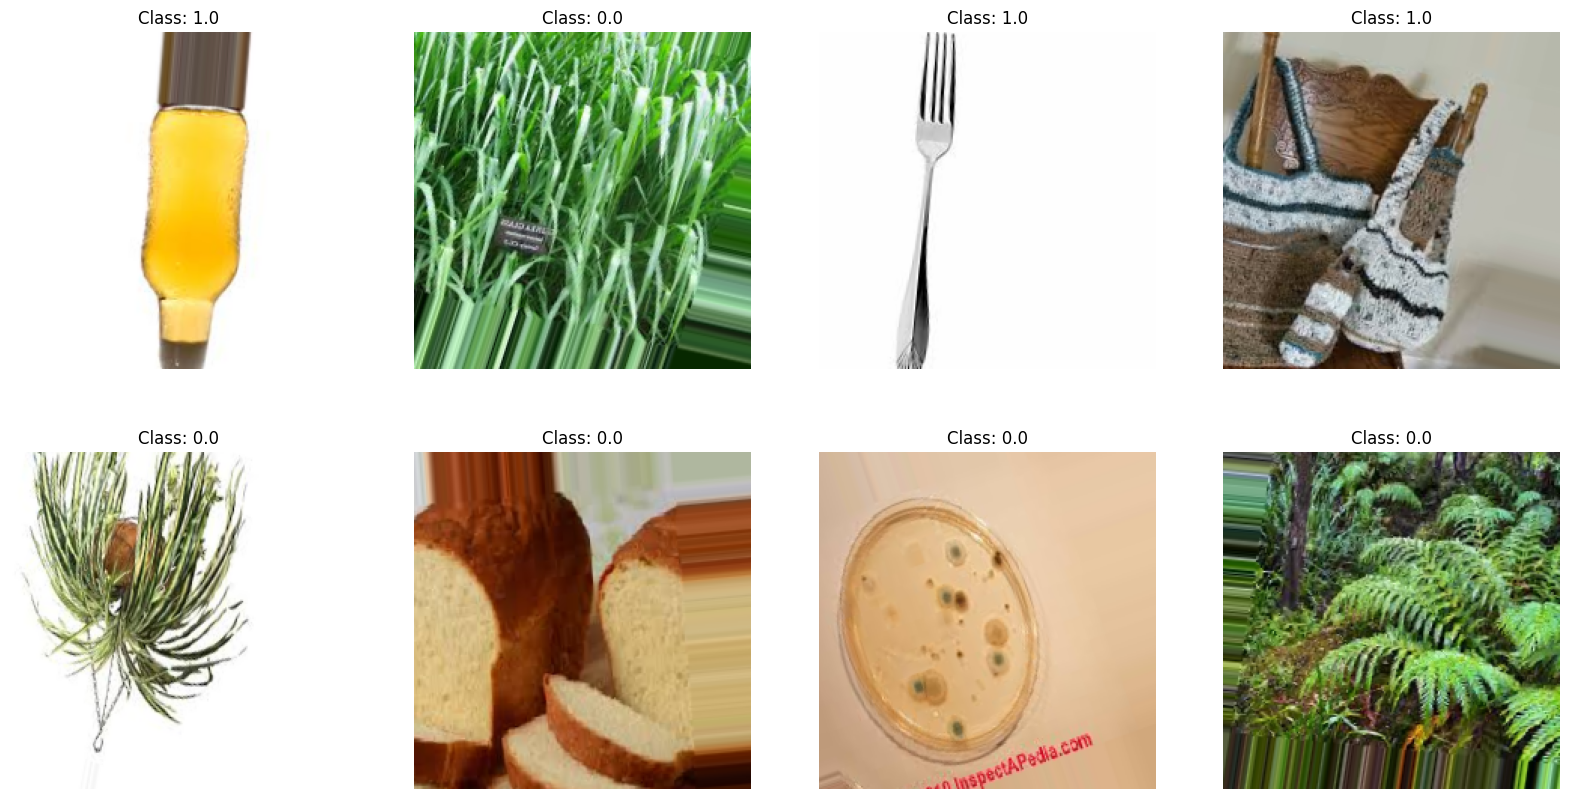

In [15]:
# Generate a batch of images
batch = next(train_generator)

# Define the number of images to display
num_images = 8

plt.figure(figsize=(20, 10))
for i in range(num_images):
    # Get an image and its label from the batch
    img = batch[0][i]
    label = batch[1][i]

    # Plot the image
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Class: {label}')
    plt.axis('off')

plt.show()

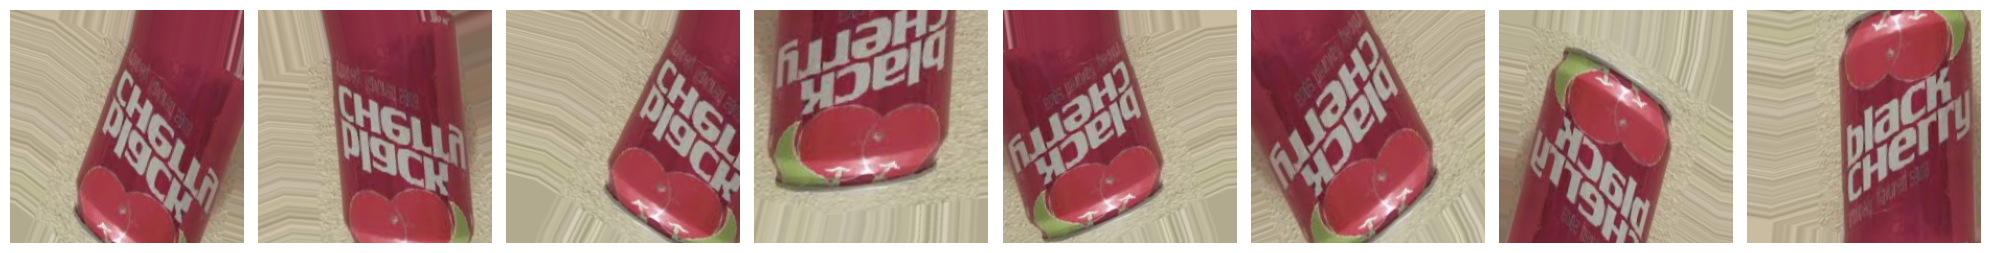

In [16]:
# Fetch a batch
batch = next(train_generator)
# Select the first image and label from the batch
img, label = batch[0][0], batch[1][0]

# Function to plot images
def plot_images(image, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    axes = axes.flatten()
    for ax in axes:
        # Apply transformation - simulates augmentation by calling .random_transform()
        # It applies the transformation defined in train_datagen to the image
        augmented_img = train_datagen.random_transform(image)

        ax.imshow(augmented_img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plotting augmented versions of the first image
plot_images(img)

## Model Building

Building the CNN model architecture. It starts with building a model by using transfer learning with pre-trained VGG16 & MobileNetV2 models.

In [17]:
image_shape = (224, 224, 3)

vgg = tf.keras.applications.VGG16(input_shape=image_shape,
                                         include_top=False,
                                         weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


Next, we freeze the CNN layers to use the base model as the feature extractor:

In [18]:
for layer in vgg.layers:
  layer.trainable = False

## Building Model

The model 1 consists of Flatten layer, then we added two Dense layers with one Dropout layer as well.

In [23]:
from tensorflow.keras.regularizers import l2

input_layer = tf.keras.Input(shape=(224, 224, 3))

# Use the VGG model as a layer in a functional manner
x = vgg(input_layer)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))(x)

# Create a new model
model1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)

The learning scheduler

In [29]:
def lr_warmup(epoch):
    warmup_epochs = 5
    initial_lr = 1e-4
    target_lr = 1e-3
    if epoch < warmup_epochs:
        return initial_lr + (target_lr - initial_lr) * (epoch / warmup_epochs)
    else:
        return target_lr

lr_warmup_callback = tf.keras.callbacks.LearningRateScheduler(lr_warmup)

# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.5,
                                                    patience=5,
                                                    min_lr=1e-6)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  restore_best_weights=True)

### Compile the Model

The model is compiled with the Adam optimizer and binary crossentropy loss function, which is appropriate for binary classification tasks. The model's performance will be evaluated based on accuracy.

In [30]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
               loss='binary_crossentropy',
               metrics=['accuracy'])

model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                1605696   
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                           

### Training Model

Finally, the model is trained for a defined number of epochs using the training dataset, with validation performed on the validation dataset. The 'fit' method returns a history object containing training and validation loss and accuracy for each epoch, which can be used for analysis of the model's performance over time.

In [ ]:
history = model1.fit(train_generator,
                      steps_per_epoch=100,
                      epochs=60,
                      validation_data=validation_generator,
                      validation_steps=50,
                      verbose=2,
                      callbacks=[lr_warmup_callback, lr_scheduler, early_stopping])

Epoch 1/60
100/100 - 57s - loss: 0.7639 - accuracy: 0.7109 - val_loss: 0.5975 - val_accuracy: 0.8431 - lr: 1.0000e-04 - 57s/epoch - 565ms/step
Epoch 2/60
100/100 - 50s - loss: 0.6460 - accuracy: 0.7691 - val_loss: 0.5954 - val_accuracy: 0.7800 - lr: 2.8000e-04 - 50s/epoch - 499ms/step
Epoch 3/60
100/100 - 49s - loss: 0.5934 - accuracy: 0.8075 - val_loss: 0.5015 - val_accuracy: 0.8706 - lr: 4.6000e-04 - 49s/epoch - 493ms/step
Epoch 4/60


### Visualizing training results for model

The plots of loss and accuracy on the training and validation sets.

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

## Testing our model

Testing the classifier model on the validation set

In [ ]:
# Flow validation images using val_datagen generator
val_visual = validation_datagen.flow_from_directory(test_dir,
                                                    target_size=image_size,
                                                    shuffle=True,
                                                    class_mode='binary')

print(val_visual.class_indices)

# Generating predictions and getting indices
val_pred_prob = model1.predict(val_visual, steps=len(val_visual), verbose=1)
val_dir_indices = val_visual.index_array

# Ensure indices are generated if not already available
if val_dir_indices is None:
    val_dir_indices = [i for i, _ in enumerate(val_visual.filenames)]

# Generating true labels based on directory structure
val_true_labels = [0 if n < 1256 else 1 for n in val_dir_indices]  # directory is sorted alphanumerically; 1st 1256: 'O', 2nd 1256: 'R'

# Converting the probabilities into binary values
val_pred_labels = [1 if n >= 0.5 else 0 for n in val_pred_prob]

print("Model predictions: " + str(val_pred_labels))
print("Actual labels:     " + str(val_true_labels))

# Determining the filepaths of misclassified waste
num_misclassified = 0
misclassified_filepaths = []
correctness = []
for pred_label, true_label, dir_index in zip(val_pred_labels, val_true_labels, val_dir_indices):
    misclassified_filepaths.append(val_visual.filepaths[dir_index])
    if pred_label != true_label:
        correctness.append('incorrect')
        num_misclassified += 1
    else:
        correctness.append('correct')

print("# of total images: " + str(len(correctness)))
print("# of misclassified images: " + str(num_misclassified))


To better visualize these results, let’s output the images of the classified waste along with correctness labels.

In [ ]:
import matplotlib.image as mpimg

# obtain images from the filepath at the determined indices
misclassified_imgs = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))

# plot first 30 images
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(correctness[count])
    else:
      axarr[r,c].set_title(correctness[count], color='red')
    axarr[r,c].set_axis_off()
    count += 1
plt.show()

# Evaluating models performance using different metrics

In [ ]:
loss, acc = model1.evaluate(validation_generator, verbose=1)
print("Accuracy using evaluate: "+str(acc))
print("Loss using evaluate: "+str(loss))

Generating the confusion matrix

In [ ]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# confusion matrix
matrix = confusion_matrix(val_true_labels, val_pred_labels, labels=[0, 1])
print('Confusion matrix : \n',matrix, '\n')

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(val_true_labels, val_pred_labels, labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn, '\n')

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(val_true_labels, val_pred_labels, labels=[1,0])
print('Classification report : \n',matrix)

In [ ]:
model1.save("tf_model_1.keras")